%pip install torchtext
%pip install wandb

In [4]:
import pandas as pd
import torch
import torchvision
from PIL import Image, ImageFile
Image.LOAD_TRUNCATED_IMAGES = True
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import nltk
nltk.download('punkt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fede\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

vocab,embeddings = [],[]
with open('glove.6B.50d.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

import numpy as np
vocab = np.array(vocab)
embs = np.array(embeddings)

#insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab = np.insert(vocab, 0, '<pad>')
vocab = np.insert(vocab, 1, '<unk>')
print(vocab[:10])

pad_emb = np.zeros((1,embs.shape[1]))   #embedding for '<pad>' token.
unk_emb = np.mean(embs,axis=0,keepdims=True)    #embedding for '<unk>' token.

#insert embeddings for pad and unk tokens at top of embs_npa.
embs = np.vstack((pad_emb,unk_emb,embs))
print(embs.shape)

In [5]:
data = pd.read_csv('../described_dataset_label.csv',sep='\t',encoding='latin-1')
data = data[:20000]
data = data.rename(columns={'FILE':'image','URL':'description'})
data = data[['image','description']]
data['image'] = [f'.{x}' for x in data['image']]
print(f'columns:{[x for x in data.columns]}')

columns:['image', 'description']


In [6]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

img_tr = [transform(Image.open(img)) for img in tqdm(data['image'])]

mean,std = img_tr[0].mean(),img_tr[0].std()

100%|██████████| 20000/20000 [04:38<00:00, 71.78it/s]


In [7]:
mean,std = img_tr[0].mean([1,2]),img_tr[0].std([1,2])
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.4685, 0.3801, 0.3472])
Std of the image: tensor([0.2129, 0.1872, 0.1589])


In [8]:
# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(data['image'],data['description'], test_size=0.2, random_state=42)
print(f'Train size:{len(X_train)} Val size:{len(y_train)}')

Train size:16000 Val size:16000


In [9]:
#Image Transformations
img_train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

img_test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

# Vocabulary Class Explanation

## Introduction
This code defines a Python class called `Vocabulary` which is designed to create and manage a vocabulary for natural language processing tasks.

## Class Initialization
- The `Vocabulary` class is initialized with a name.
- It initializes three tokens (`PAD_token`, `SOS_token`, `EOS_token`) which are used for padding short sentences, marking the start of a sentence, and marking the end of a sentence respectively.
- It initializes dictionaries to store mappings between words and indices, and vice versa.
- It also tracks the number of words, sentences, and the length of the longest sentence.

## Method: add_word
- This method adds a word to the vocabulary.
- If the word is not already in the vocabulary, it assigns it a unique index and initializes its count to 1.
- If the word already exists in the vocabulary, it simply increments its count.

## Method: add_sentence
- This method adds a sentence to the vocabulary.
- It splits the sentence into words, adds each word using the `add_word` method, and updates the length of the longest sentence.
- It also increments the count of sentences.

## Method: to_word
- This method converts an index to its corresponding word in the vocabulary.

## Method: to_index
- This method converts a word to its corresponding index in the vocabulary.

## Method: len
- This method returns the total number of words in the vocabulary.

## Usage
- After defining the `Vocabulary` class, an instance of it named `vocab` is created with the name 'art'.
- Then, it iterates through sentences (presumably contained in a variable called `data['description']`), tokenizes each sentence into words using NLTK's `word_tokenize` function, and adds each word to the vocabulary using the `add_word` method.

In [10]:
from nltk.tokenize import word_tokenize
class Vocabulary:
    
    def __init__(self, name):
        self.name = name
        PAD_token = 0   # Used for padding short sentences
        SOS_token = 1   # Start-of-sentence token
        EOS_token = 2   # End-of-sentence token
        self.word2index = {"PAD": PAD_token, "SOS": SOS_token, "EOS": EOS_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3
        self.num_sentences = 0
        self.longest_sentence = 0

    def add_word(self, word):
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0
        for word in sentence.split(' '):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]
    
    def len(self):
        return self.num_words

vocab = Vocabulary('art')
for sentence in tqdm(data['description']):
    sentence = word_tokenize(sentence)
    for word in sentence:
        vocab.add_word(word)

100%|██████████| 20000/20000 [00:08<00:00, 2274.31it/s]


# ArtDataset Class Explanation

## Introduction
This code defines a custom dataset class `ArtDataset` for handling image and caption data. It's designed to be compatible with PyTorch's `torch.utils.data.Dataset` class.

## Class Initialization
- The `ArtDataset` class is initialized with image data, corresponding labels (captions), an optional transformation for images, and a maximum caption length.
- It stores these parameters as attributes for later use.

## Method: __len__
- This method returns the length of the dataset, which is the number of samples (images) in the dataset.

## Method: __getitem__
- This method is used to retrieve a single item (image and caption pair) from the dataset given an index.
- It loads the image corresponding to the index using PIL's `Image.open` function and converts it to RGB format.
- If a transformation is provided, it applies the transformation to the image.
- It tokenizes the caption using NLTK's `word_tokenize` function, appending start-of-sentence (`SOS`) and end-of-sentence (`EOS`) tokens to the tokenized caption.
- If the length of the tokenized caption exceeds the maximum caption length, it truncates it; otherwise, it pads it with `PAD` tokens to match the maximum length.
- It then converts the tokens to indices using a predefined vocabulary (`vocab`) and creates a PyTorch tensor from the indices.
- Finally, it returns a tuple containing the processed image and the tokenized caption.

## Dataset Instantiation
- After defining the `ArtDataset` class, two instances of it (`train_dataset` and `val_dataset`) are created using training and validation data (`X_train`, `y_train`, `X_val`, `y_val`), respectively.
- Transformation functions (`img_train_transform` and `img_test_transform`) are applied to the images if provided.



In [11]:
from nltk.tokenize import word_tokenize
class ArtDataset(torch.utils.data.Dataset):

    def __init__(self,images,labels,transform=None, max_caption_length=50):
        self.data = images
        self.labels = labels
        self.transform = transform
        self.max_caption_length = max_caption_length

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_pil = Image.open(self.data[index])
        img_pil = img_pil.convert('RGB')
        if self.transform is not None:
            img_pil = self.transform(img_pil)
        else:
            tr1 = transforms.ToTensor()
            img_pil = tr1(img_pil)

        #Tokenize caption using nltk
        caption = self.labels[index]
        tokens = []
        tokens.append('SOS')
        tokens.extend(word_tokenize(caption))
        tokens.append('EOS')
        if len(tokens) > self.max_caption_length:
            tokens = tokens[:self.max_caption_length]
        else:
            tokens += ["PAD"] * (self.max_caption_length - len(tokens))
        #Convert tokens to indices
        caption = [vocab.to_index(token) for token in tokens]

        tokenized_caption = torch.LongTensor(caption)
        return(img_pil,tokenized_caption)

train_dataset = ArtDataset(X_train[:13500].values,y_train[:13500].values,transform=img_train_transform)
val_dataset = ArtDataset(X_train[13500:].values,y_train[13500:].values,transform=img_test_transform)
test_dataset = ArtDataset(X_val.values,y_val.values,transform=img_test_transform)

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: 32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


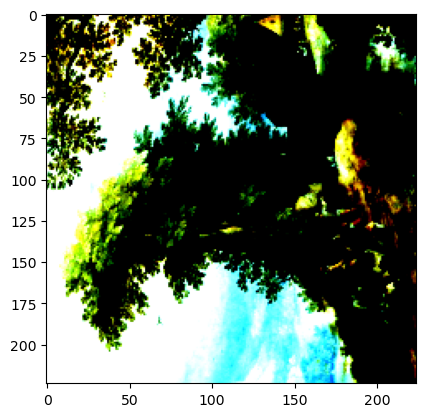

In [12]:
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
features, labels = next(iter(trainloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {len(labels)}")
img = features[0].squeeze()
plt.imshow(img.permute(*torch.arange(img.ndim - 1, -1, -1)))
plt.show()
# print(f"Label_tokenized: {labels}")
# print(f"Label: {[vocab.to_word(x) for x in labels[0]]}")

In [13]:
del data
del X_train,X_val,y_train,y_val

## Show Attend and Tell model

## Introduction
This markdown provides a more detailed explanation of the Show and Tell model code, focusing on the rationale behind the architectural choices made.

## Encoder
### Explanation:
- The `Encoder` class employs a pre-trained ResNet-50 model for image feature extraction.
  - **Rationale**: ResNet-50 is a deep convolutional neural network known for its effectiveness in image classification tasks. By utilizing a pre-trained ResNet-50 model, the encoder benefits from the high-level features learned from a large dataset (like ImageNet), allowing it to capture rich image representations.
- The encoder freezes the ResNet-50 weights and removes the last fully connected layer.
  - **Rationale**: Freezing the weights prevents them from being updated during training, which helps preserve the learned features of the ResNet-50 model. Removing the last fully connected layer simplifies the model and prepares it for feature extraction.
- The extracted features are projected onto a lower-dimensional space using a linear layer.
  - **Rationale**: Projecting the high-dimensional features onto a lower-dimensional space reduces computational complexity while retaining the most relevant information. This helps in training and improves generalization.

## Attention
### Explanation:
- The `Attention` mechanism calculates attention weights based on the similarity between encoder features and decoder hidden states.
  - **Rationale**: By calculating attention weights, the model can dynamically focus on different parts of the image when generating captions. This enables the model to attend to relevant image regions while generating each word of the caption, improving the quality and relevance of the generated captions.
- The attention weights are used to compute a weighted sum of encoder features, providing context information to the decoder.
  - **Rationale**: Incorporating context information helps the decoder generate more informative and coherent captions by considering relevant image regions at each decoding step.

## Decoder
### Explanation:
- The `Decoder` class generates captions based on the extracted features and attention mechanism.
  - **Rationale**: By using an LSTM-based decoder, the model can capture the sequential nature of language and generate captions word by word. The LSTM's ability to retain long-term dependencies helps in generating coherent and contextually relevant captions.
- The decoder employs an LSTM to generate a sequence of words.
  - **Rationale**: LSTMs are well-suited for sequential data modeling tasks like language generation. They can capture dependencies between words in a sentence, making them suitable for generating captions.
- At each step, the attention mechanism provides context information to the decoder.
  - **Rationale**: Incorporating attention helps the model focus on relevant image regions while generating each word of the caption, improving the overall quality of the generated captions.
- The decoding process continues until an end token is generated or a maximum sequence length is reached.
  - **Rationale**: Ending the caption generation process upon encountering an end token ensures that the model produces captions of fixed length. Additionally, imposing a maximum sequence length helps prevent the model from generating overly long or repetitive captions, enhancing the efficiency and relevance of the generated captions.

## Summary
This detailed explanation highlights the rationale behind the architectural choices made in the Show and Tell model. By leveraging pre-trained ResNet-50 for feature extraction, incorporating attention mechanism for context-aware caption generation, and using LSTM-based decoder for sequential language modeling, the model achieves the capability to generate descriptive and contextually relevant captions for images. These choices are grounded in the principles of effective feature representation, attentional focus, and sequential modeling, enabling the model to produce high-quality image captions.


In [14]:
from torchvision.models.densenet import DenseNet201_Weights
class Encoder(nn.Module):
    def __init__(self, embed_dim, batch_norm_momentum=0.9, dropout=0.5) -> None:
        super(Encoder,self).__init__()
        # resnet = torchvision.models.resnet50(weights="ResNet50_Weights.DEFAULT")
        # resnet = torchvision.models.resnext101_64x4d(pretrained=True)
        self.dense_net = torchvision.models.densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)
        for param in self.dense_net.parameters():
            param.requires_grad = False
        
        #Adjusting the output features according to the embed_dim
        self.embed = nn.Linear(self.dense_net.classifier.out_features,embed_dim)
        self.batch = nn.BatchNorm1d(embed_dim,momentum=batch_norm_momentum)
        self.dropout = nn.Dropout(dropout)

        #Initializing the weights and bias
        self.embed.weight.data.normal_(0.0,0.1)
        self.embed.bias.data.fill_(0)


    def forward(self,imgs):
        features = self.dense_net(imgs)
        features = self.dropout(features)
        features = self.embed(features)
        features = self.batch(features)
        
        return features

In [15]:
class Attention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim, attention_dim) -> None:
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)#U
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)#W
        self.full_att = nn.Linear(attention_dim,1)#V
        

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1) # W * decoder_hidden
        att = F.relu(att1+att2) # ReLU(U * encoder_out + W * decoder_hidden)
        att = self.full_att(att).squeeze(2) # V * ReLU(U * encoder_out + W * decoder_hidden)
        alpha = F.softmax(att, dim=1) # attention weights
        attention_weighted_encoding = torch.sum(encoder_out * alpha,dim=1).squeeze(1) # attention_weighted_encoding

        return attention_weighted_encoding, alpha

In [16]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size,dropout=0.5):
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.attention = Attention(embed_size, hidden_size, hidden_size)

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.f_beta = nn.Linear(hidden_size, embed_size)
        self.sigmoid = nn.Sigmoid()

        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        features = features.unsqueeze(1)
        embeddings = torch.cat((features, embeddings[:,:-1,:]), dim=1)
        hidden, _ = self.lstm(embeddings)
        attention_weighted_encoding, _ = self.attention(features, hidden)
        gate = self.sigmoid(self.f_beta(hidden))
        attention_weighted_encoding = gate * attention_weighted_encoding
        # inputs = torch.cat((embeddings[:, :-1, :], attention_weighted_encoding), dim=1) #Combined lstm output and attention weighted encoding in a single tensor, reduces the number of LSTM iterations.
        inputs = torch.cat((embeddings,attention_weighted_encoding))
        lstm_out, _ = self.lstm(inputs)
        
        outputs = self.linear(self.dropout(lstm_out))
        
        return outputs
    
    def sample(self,features, max_len=50):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        states = None

        for _ in range(max_len):
            hiddens, states = self.lstm(inputs, states)          
            outputs = self.linear(hiddens)
            out = outputs.squeeze(1)    
            predicted = torch.argmax(out,dim=1)
            sampled_ids.append(predicted.cpu().numpy()[0].item())
            inputs = self.embedding(predicted).unsqueeze(1)                 
        # sampled_ids = torch.stack(sampled_ids,1)
        return sampled_ids
    
    #Top-k + Nucleus Sampling
    def sample_combined_sampling(self, features, max_len=50, temperature=1.0, top_k=0, top_p=0.0):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        states = None
        
        for _ in range(max_len):
            hiddens, states= self.lstm(inputs, states)
            outputs = self.linear(hiddens)/temperature
            if top_k > 0:
                outputs = self.top_k_sampling(outputs, top_k)
            elif top_p < 1.0:
                outputs = self.nucleus_sampling(outputs,top_p)
            out = outputs.squeeze(1)    
            predicted = torch.argmax(out,dim=1)
            sampled_ids.append(predicted.cpu().numpy()[0].item())
            inputs = self.embedding(predicted).unsqueeze(1) 
        # sampled_ids = torch.stack(sampled_ids,1)
        return sampled_ids

#Operates directly on logits and not softmax probabilities
    def top_k_sampling(self, logits, k):
        with torch.no_grad():
            top_values, top_indices = torch.topk(logits, k, dim=-1)
            min_value = top_values[:, -1].unsqueeze(-1)
            logits = torch.where(logits < min_value, torch.tensor(-float('inf'), device=logits.device), logits)
        return logits

    def nucleus_sampling(self, logits, p):
        with torch.no_grad():
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_indices_to_remove = cumulative_probs > p
            sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
            sorted_indices_to_remove[:, 0] = 0
            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            logits[indices_to_remove] = -float('inf')
        return logits


# `train` Function Explanation

## Introduction
This function is responsible for training the Show and Tell model using the provided data and optimizer.

## Function Parameters
- `train_loader`: The data loader for training images and captions.
- `encoder`: The encoder model responsible for extracting image features.
- `decoder`: The decoder model responsible for generating captions.
- `criterion`: The loss function used to compute the training loss.
- `encoder_optimizer`: The optimizer used to update the parameters of the encoder model (can be `None` if the encoder is frozen).
- `decoder_optimizer`: The optimizer used to update the parameters of the decoder model.
- `epoch`: The current epoch number.

## Training Loop
- The function iterates over the batches of training data provided by `train_loader`.
- For each batch:
  - It moves the images and captions to the appropriate device (CPU or GPU).
  - It computes the lengths of the captions in the batch.
  - It passes the images through the encoder to obtain image features.
  - It passes the image features and captions through the decoder to obtain predicted scores for each word in the captions.
  - It packs the predicted scores and the ground truth captions using `pack_padded_sequence` to handle variable-length sequences.
  - It computes the loss between the predicted scores and the ground truth captions using the provided loss function (`criterion`).
  - It backpropagates the loss and updates the parameters of the decoder (and optionally the encoder) using the specified optimizers (`decoder_optimizer` and `encoder_optimizer`).
  - It logs the current loss for monitoring training progress.
  - It updates the progress bar with information about the current epoch, batch number, and loss.

## Logging
- The function logs the loss for each batch using Weights & Biases (`wandb`) for monitoring training progress.
- It also appends the mean loss for the entire epoch to the `train_loss` list for further analysis or visualization.

In [17]:
def train(encoder, decoder,encoder_optimizer, decoder_optimizer, criterion, train_loader, val_loader, epochs=10, early_stopping_patience=25):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    #Train the model
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            encoder.train()
            decoder.train()
            train_loss = 0.0
            for i, (images, captions) in enumerate(train_loader,0):
                images, captions = images.to(device), captions.to(device)
                encoder_optimizer.zero_grad() if encoder_optimizer else None
                decoder_optimizer.zero_grad()
                
                features = encoder(images)
                outputs = decoder(features, captions)

                #Flatten the outputs and the captions
                decode_lengths = [len(cap) for cap in captions]
                outputs = nn.utils.rnn.pack_padded_sequence(outputs, decode_lengths, batch_first=True, enforce_sorted=False)
                captions = nn.utils.rnn.pack_padded_sequence(captions, decode_lengths, batch_first=True, enforce_sorted=False)

                loss = criterion(outputs.data,captions.data)
                
                loss.backward()
                encoder_optimizer.step() if encoder_optimizer else None
                decoder_optimizer.step()

                train_loss += loss.item()

            train_losses.append(train_loss/len(train_loader))

            #Validation of the model
            encoder.eval()
            decoder.eval()
            val_loss = 0.0
            with torch.no_grad():
                for img,captions in val_loader:
                    img,captions = img.to(device),captions.to(device)
                    features = encoder(img)
                    outputs = decoder(features, captions)
                    decode_lengths = [len(cap) for cap in captions]
                    outputs = nn.utils.rnn.pack_padded_sequence(outputs, decode_lengths, batch_first=True, enforce_sorted=False)
                    captions = nn.utils.rnn.pack_padded_sequence(captions, decode_lengths, batch_first=True, enforce_sorted=False)
                    loss = criterion(outputs.data,captions.data)
                    val_loss += loss.item()
            val_losses.append(val_loss/len(val_loader))

            #Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    print(f'Early stopping! Epoch: {epoch+1}')
                    break

            pbar.set_description(f'Train Loss: {train_losses[-1]:.3f} | Val Loss: {val_losses[-1]:.3f}')
            pbar.update(1)

    return train_losses, val_losses

In [18]:
import matplotlib.pyplot as plt

def plot_loss(loss_values, title="Loss Plot"):
    """
    Plot the loss values over training epochs.

    Parameters:
    - loss_values: A list or array of loss values for each epoch.
    - title: The title of the plot (optional).
    """
    plt.figure(figsize=(10, 6))
    plt.plot(loss_values[0], marker='o', linestyle='-', label='train')
    plt.plot(loss_values[1], marker='o', linestyle='-',label='val')
    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

### Optimizing the Model with Optuna

In [19]:
#Define the function to convert the predicted ids to words
def convert_to_words(sampled_ids):
    sampled_caption = []
    for word_id in sampled_ids:
        word_id = int(word_id)
        word = vocab.index2word[word_id]
        sampled_caption.append(word)
        if word == 'EOS':
            break
    sentence = ' '.join(sampled_caption)
    return sentence

In [20]:
#Define the prediction function
def predict(encoder, decoder,image, top_k, top_p, max_len=50, temperature=1.0):
    encoder.eval()
    decoder.eval()
    image = image.to(device)
    feature = encoder(image)
    sampled_ids = []
    sampled_ids = decoder.sample_combined_sampling(feature, max_len=max_len, temperature=temperature, top_k=top_k, top_p=top_p)
    return sampled_ids

In [21]:
from datasets import load_metric

def rouge_score(encoder, decoder, data_loader, top_p, top_k):
    rouge = load_metric('rouge')
    predictions = []
    references = []
    for img, label in data_loader: 
        res = predict(encoder, decoder, img, top_k=top_k, top_p=top_p)
        sentence = convert_to_words(res)
        predictions.append(sentence)
        references.append(label)
    result = rouge.compute(predictions=predictions, references=references, use_aggregator=True)
    return result["rougeL"].mid.fmeasure


In [22]:
# import optuna

# def objective(trial):
#     # Define search space for hyperparameters
#     learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1,log=True)
#     batch_size = trial.suggest_categorical('batch_size', [32, 64])
#     early_stopping_patience = trial.suggest_int('early_stopping_patience', 5, 25)
#     weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)
#     dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, log=True)
#     top_k = trial.suggest_categorical('top_k', [0, 1])
#     top_p = trial.suggest_categorical('top_p', [0.0, 1.0])

#     # Train the model with current hyperparameters

#     encoder = Encoder(embed_dim=512).to(device)
#     decoder = Decoder(embed_size=512, hidden_size=512, vocab_size=vocab.len(),dropout=dropout_rate).to(device)
#     optimizer_encoder = torch.optim.AdamW(encoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     optimizer_decoder = torch.optim.AdamW(decoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     criterion = nn.CrossEntropyLoss()
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#     _,val_loss = train(encoder, decoder, optimizer_encoder, optimizer_decoder, criterion, train_loader, val_loader, epochs=30, early_stopping_patience=early_stopping_patience)
#     accuracy = rouge_score(encoder, decoder, val_loader, top_p=top_p, top_k=top_k)
#     return accuracy

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Get the best hyperparameters and accuracy
# best_params = study.best_params
# best_accuracy = study.best_value

# print("Best hyperparameters Author:", best_params)
# print("Best accuracy Author:", best_accuracy)

## Train and Hyperparams

In [23]:
#Parameters and Hyperparameters

#Model Parameters
embed_dim = 200
attention_dim = 224
decoder_dim = 224
dropout = 1.27e-01
batch_norm_momentum = 0.9

#Training Hyperparameters
epochs = 30
encoder_lr = 1.65e-02
decoder_lr = 1.65e-02
weight_decay = 1.55e-06
alpha_c = 1.0
fine_tune_encoder = False
checkpoint = None


In [24]:
decoder = Decoder(embed_size=embed_dim, hidden_size=decoder_dim, vocab_size=vocab.len(),dropout=dropout).to(device)
encoder = Encoder(embed_dim, batch_norm_momentum=batch_norm_momentum, dropout=dropout).to(device)

parameters = list(decoder.parameters())+list(encoder.embed.parameters())
decoder_optimizer = optim.AdamW(filter(lambda p: p.requires_grad, parameters), lr=decoder_lr, weight_decay=weight_decay)
encoder_optimizer = optim.AdamW(filter(lambda p: p.requires_grad, encoder.parameters()), lr=encoder_lr, weight_decay=weight_decay) if fine_tune_encoder else None
 
criterion = nn.CrossEntropyLoss() 
train_loss, val_loss = train(encoder,decoder,encoder_optimizer,decoder_optimizer,criterion,trainloader,valloader,epochs=epochs)

Train Loss: 2.542 | Val Loss: 5.546:  90%|█████████ | 27/30 [1:56:56<12:59, 259.86s/it]

Early stopping! Epoch: 28


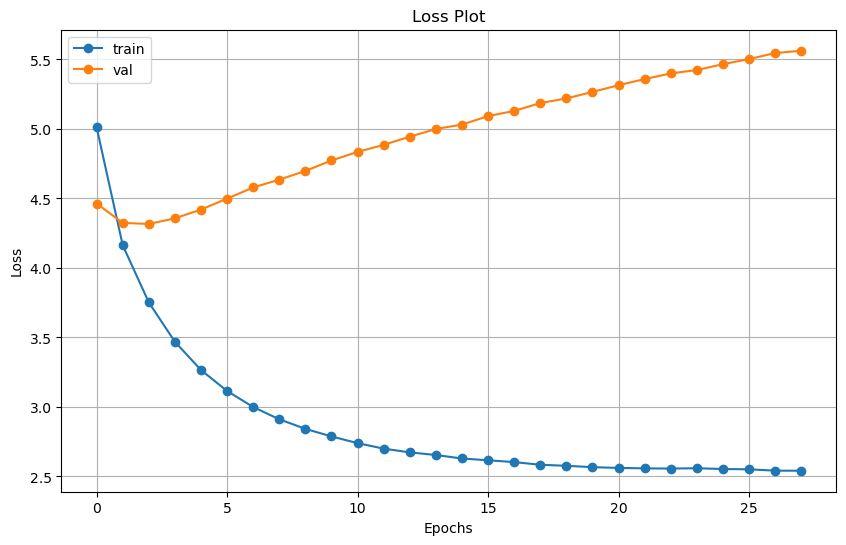

In [25]:
plot_loss([train_loss,val_loss])

# `evaluate` Function Explanation

## Introduction
This function is responsible for evaluating the performance of the Show and Tell model on the validation dataset.

## Function Parameters
- `valloader`: The data loader for validation images and captions.
- `encoder`: The encoder model used for feature extraction.
- `decoder`: The decoder model used for caption generation.
- `loss_fn`: The loss function used to compute the evaluation loss.

## Evaluation Loop
- The function iterates over the batches of validation data provided by `valloader`.
- For each batch:
  - It moves the images and captions to the appropriate device (CPU or GPU).
  - It passes the images through the encoder to obtain image features.
  - It passes the image features and ground truth captions through the decoder to obtain predicted scores for each word in the captions.
  - It computes the loss between the predicted scores and the ground truth captions using the provided loss function (`loss_fn`).
  - It logs the current loss for the batch for monitoring evaluation progress.

## Logging
- The function logs the loss for each batch using Weights & Biases (`wandb`) for monitoring evaluation progress.



# `bleu_score` Function Explanation

## Introduction
This function computes the BLEU (Bilingual Evaluation Understudy) score for the generated captions by the Show and Tell model on the validation dataset.

## Function Parameters
- `valloader`: The data loader for validation images and captions.
- `encoder`: The encoder model used for feature extraction.
- `decoder`: The decoder model used for caption generation.

## BLEU Score Computation
- The function imports the `load_metric` function from the `datasets` library, which is used to load the BLEU metric.
- It sets the encoder and decoder models to evaluation mode using the `eval()` method.
- The function iterates over the batches of validation data provided by `valloader`.
- For each batch:
  - It moves the images to the appropriate device (CPU or GPU).
  - It extracts features from the images using the encoder.
  - It generates captions for the images using the decoder's `sample_beam_search` method.
  - It converts the indices of the generated captions to actual words using the vocabulary (`vocab`).
  - It adds the generated captions and ground truth captions to the BLEU metric using the `add` method.
- Finally, the function computes the BLEU score using the `compute` method of the BLEU metric.

## BLEU Score
- The BLEU score is a metric commonly used to evaluate the quality of machine-translated text. It measures the similarity between the generated captions and the ground truth captions by computing the precision of n-grams (typically up to 4-grams) in the generated captions compared to the reference captions.

## Summary
This function evaluates the quality of the generated captions by computing the BLEU score, providing a quantitative measure of the model's performance in generating captions that are similar to the ground truth captions.


In [26]:
from datasets import load_metric
#BLEU Score
def bleu_score(valloader,encoder,decoder,vocab):
    bleu_score = load_metric("bleu")
    encoder.eval()
    decoder.eval()

    for _ , (images,descriptions) in enumerate(valloader,0):
        images = images.to(device)
        # descriptions = descriptions.to(device)
        features = encoder(images)
        outputs = decoder.sample_combined_sampling(features)

        outputs = [vocab.to_word(x) for x in outputs]
        # print(outputs)
        bleu_score.add(predictions=outputs,references=descriptions)

    return bleu_score.compute()

In [27]:
results = rouge_score(encoder,decoder,testloader,top_p=1.0,top_k=0)
print(f"Rouge Score: {results}")

C:\Users\Fede\AppData\Local\Temp\ipykernel_16404\3671032434.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric('rouge')


Rouge Score: 2.02020202020202e-05


# `convert_to_words` Function Explanation

## Introduction
This function converts the predicted word indices generated by the decoder into actual words using the vocabulary mapping.

## Function Parameters
- `sampled_ids`: A list of predicted word indices generated by the decoder.

## Conversion Process
- The function iterates over the predicted word indices (`sampled_ids`).
- For each word index, it retrieves the corresponding word from the vocabulary using the `index2word` mapping.
- It appends the word to the `sampled_caption` list.
- If the word is 'EOS' (end-of-sentence token), it stops the iteration as the caption is complete.
- Finally, it joins the words in the `sampled_caption` list to form the final caption sentence.

## Summary
This function plays a crucial role in converting the output of the decoder (predicted word indices) into human-readable captions. It utilizes the vocabulary mapping (`index2word`) to perform the conversion, enabling the model to generate descriptive captions for images.


In [28]:
#Define the function to display the image and the predicted caption
def display_image_caption(image,sentence):
    plt.imshow(image.squeeze().permute(1,2,0))
    plt.title(sentence)
    plt.show()

In [29]:
#Define the function to display the image and the actual caption
def display_image_caption_actual(image, label):
    plt.imshow(image.squeeze().permute(1,2,0))
    plt.title(convert_to_words(tuple(label.numpy())))
    plt.show()

In [31]:

#img, label = next(iter(testloader))
for img, label in testloader:
    # display_image_caption_actual(img[:1], label[:1])
    # plt.imshow(img.squeeze().permute(1,2,0))
    img = img.to(device)
    res = predict(encoder,decoder,img, top_k=1, top_p=1.0, max_len=500, temperature=0.4)
    sentence = convert_to_words(res)
    print(f"Predicted: {sentence}")

Predicted: SOS The painting depicts a still-life of a roemer of wine , a queen of boiling water , a herder and sheep . The painting is signed and dated lower left : DrÃ¶lling Rt 1815 . EOS
Predicted: SOS This painting is a copy of the artist 's work . EOS
Predicted: SOS The detail shows the head of the Madonna and Child . EOS
Predicted: SOS The picture shows the left wing of the Portinari Triptych of the Virgin and Child . EOS
Predicted: SOS The painting depicts a still-life of a roemer of wine , a queen of boiling water , a herder and sheep . The painting is signed and dated lower left : DrÃ¶lling Rt 1815 . EOS
Predicted: SOS The painting depicts a still-life of a roemer of wine , a queen of boiling water , a herder and sheep . The painting is signed and dated lower left : DrÃ¶lling Rt 1815 . EOS
Predicted: SOS The picture shows the left wing of the Portinari Triptych of the Virgin and Child . EOS
Predicted: SOS The picture shows the left wing of the Portinari Triptych of the Virgin a